# Imports

In [1]:
import datetime
import functools
import os
import sys
from typing import Callable, Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange

from PyTorch_VAE import models
from diffusion_policy.common.sampler import get_val_mask
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset

# Plotting

In [2]:
def plot_losses(train_losses, test_losses):
    # Plot train and test losses.
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.linspace(0, len(train_losses), len(test_losses)),
        test_losses,
        label="Test Loss",
    )
    # Remove outliers for better visualization
    # plt.ylim(0, 0.01)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Load dataset

In [3]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# path = "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"
# path = '/home/matteogu/ssd_data/data_diffusion/pusht/pusht_cchi_v7_replay.zarr'

dataset = PushTImageDataset(path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)

In [4]:
def normalize_pn1(x, min_val, max_val):
    # Normalize to [0, 1]
    nx = (x - min_val) / (max_val - min_val)
    # Normalize to [-1, 1]
    return nx * 2 - 1


def denormalize_pn1(nx, min_val, max_val):
    # Denormalize from [-1, 1]
    x = (nx + 1) / 2
    # Denormalize from [0, 1]
    return x * (max_val - min_val) + min_val


# Make the state normalizer.
max_state = dataset.replay_buffer["state"].max(axis=0)
min_state = np.zeros_like(max_state)

In [15]:
class EpisodeDataset(Dataset):
    def __init__(
        self,
        dataset,
        n_obs_history=1,
        n_pred_horizon=1,
        episode_idxs=None,
        include_keys: Optional[list[str]] = None,
        process_fns: Optional[dict[str, Callable]] = None,
        device: str = "cpu",
    ):
        """
        Initialize the dataset with the main dataset object that contains
        the replay_buffer. Also, specify the lengths of observation history
        and prediction horizon.
        """
        self.dataset = dataset
        self.n_obs_history = n_obs_history
        self.n_pred_horizon = n_pred_horizon
        self.episode_idxs = list(episode_idxs)
        self.include_keys = set(include_keys) if include_keys is not None else None
        if not self.include_keys:
            raise ValueError("At least one key must be included in the dataset.")
        self.process_fns = process_fns
        self.device = device
        self.prepare_data()

    def prepare_data(self):
        """
        Preprocess the episodes to create a flat list of samples.
        Each sample is a tuple of dictionaries: (obs_history, pred_horizon).
        """
        self.samples = []

        if self.episode_idxs is None:
            self.episode_idxs = range(self.dataset.replay_buffer.n_episodes)

        for episode_idx in tqdm(self.episode_idxs, desc="Preparing data"):
            episode = self.dataset.replay_buffer.get_episode(episode_idx)

            obs = {}

            if self.include_keys is None or "img" in self.include_keys:
                img = episode["img"].transpose(0, 3, 1, 2)  # CHW format
                if "img" in self.process_fns:
                    img = self.process_fns["img"](img)
                obs["img"] = torch.tensor(img, dtype=torch.float32).to(self.device)

            if self.include_keys is None or "action" in self.include_keys:
                action = episode["action"]
                if "action" in self.process_fns:
                    action = self.process_fns["action"](action)
                obs["action"] = torch.tensor(action, dtype=torch.float32).to(
                    self.device
                )

            if self.include_keys is None or "state" in self.include_keys:
                state = episode["state"]
                if "state" in self.process_fns:
                    state = self.process_fns["state"](state)
                obs["state"] = torch.tensor(state, dtype=torch.float32).to(self.device)

            # Iterate through the episode to create samples with observation history and prediction horizon
            n_obs = len(list(obs.values())[0])
            for i in range(n_obs - self.n_obs_history - self.n_pred_horizon + 1):
                obs_history = {}
                pred_horizon = {}

                for key, value in obs.items():
                    obs_history[key] = value[i : i + self.n_obs_history]
                    pred_horizon[key] = value[
                        i
                        + self.n_obs_history : i
                        + self.n_obs_history
                        + self.n_pred_horizon
                    ]

                self.samples.append((obs_history, pred_horizon))

    def __len__(self):
        """
        Return the total number of samples across all episodes.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return the idx-th sample from the dataset.
        """
        obs_history, pred_horizon = self.samples[idx]

        # Convert data to PyTorch tensors and ensure the data type is correct
        # for key, value in obs_history.items():
        #     obs_history[key] = torch.tensor(value, dtype=torch.float32)
        # for key, value in pred_horizon.items():
        #     pred_horizon[key] = torch.tensor(value, dtype=torch.float32)

        return obs_history, pred_horizon

# Diffusion

## Models

In [16]:
class DiffusionMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(DiffusionMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),  # Predicting epsilon
        )

    def forward(self, x, t):
        t = t.reshape(-1, 1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

## Train/eval impl

In [17]:
def warmup_cosine_decay_scheduler(optimizer, warmup_steps, total_steps):
    """
    Creates a scheduler with warmup followed by cosine decay.

    Args:
        optimizer: Optimizer linked to the model parameters.
        warmup_steps: Number of steps for the warmup phase.
        total_steps: Total number of steps in the training.
    """

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay
        progress = float(current_step - warmup_steps) / float(
            max(1, total_steps - warmup_steps)
        )
        return 0.5 * (1.0 + np.cos(np.pi * progress))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def dropout_classes(y, null_class, dropout_prob=0.1):
    """Randomly dropout classes with a given probability."""
    dropout_mask = torch.rand(y.shape) < dropout_prob
    y[dropout_mask] = null_class
    return y


class Diffusion(object):
    def __init__(
        self,
        train_data=None,
        test_data=None,
        model=None,
        batch_size=1024,
        n_epochs=100,
        n_warmup_steps=100,
        has_labels=False,
        obs_normalizer=None,
        device: str = "cuda",
    ):
        if has_labels:
            raise NotImplementedError()

        self.n_epochs = n_epochs
        self.has_labels = has_labels
        self.device = device

        self.obs_normalizer = (
            obs_normalizer if obs_normalizer is not None else lambda x: x
        )

        # Data loaders
        if isinstance(train_data, torch.utils.data.DataLoader):
            assert isinstance(test_data, torch.utils.data.DataLoader)
            self.train_loader = train_data
            self.test_loader = test_data
            train_data_shape = None
        elif train_data is not None:
            assert test_data is not None
            train_data_shape = train_data.shape
            self.train_loader, self.test_loader = self.create_loaders(
                train_data, test_data, batch_size
            )
        else:
            self.train_loader = None
            self.test_loader = None

        if model is None:
            assert train_data_shape is not None and len(train_data_shape) == 2
            input_dim = train_data_shape[1]
            self.model = DiffusionMLP(input_dim, input_dim)
        else:
            self.model = model
        self.model = self.model.to(device)

        def model_with_labels(x, labels, t, **kwargs):
            return self.model(x, labels, t, **kwargs)

        def model_without_labels(x, labels, t):
            return self.model(x, t)

        if has_labels:
            self.model_fn = model_with_labels
        else:
            self.model_fn = model_without_labels

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # LR scheduler
        if self.train_loader is not None:
            n_iters_per_epoch = len(self.train_loader)
            n_iters = n_epochs * n_iters_per_epoch
            self.scheduler = warmup_cosine_decay_scheduler(
                self.optimizer, n_warmup_steps, n_iters
            )
        else:
            self.scheduler = None

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def create_loaders(self, train_data, test_data, batch_size):
        train_data = torch.tensor(train_data, dtype=torch.float32)
        test_data = torch.tensor(test_data, dtype=torch.float32)

        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=False
        )
        return train_loader, test_loader

    def get_alpha(self, t):
        return torch.cos(np.pi / 2 * t).to(self.device)

    def get_sigma(self, t):
        return torch.sin(np.pi / 2 * t).to(self.device)

    def compute_loss(self, x, labels=None):
        batch_size = x.shape[0]

        # Step 1: Sample diffusion timestep uniformly in [0, 1]
        t = torch.rand(batch_size, device=self.device)  # [batch_size]

        # Step 2: Compute noise-strength
        alpha_t = self.get_alpha(t)
        sigma_t = self.get_sigma(t)

        # Step 3: Apply forward process
        epsilon = torch.randn_like(x, device=self.device)
        exp_shape = [batch_size] + [1] * (len(x.shape) - 1)
        alpha_t = alpha_t.view(exp_shape)
        sigma_t = sigma_t.view(exp_shape)
        x_t = alpha_t * x + sigma_t * epsilon  # x.shape

        # Step 4: Estimate epsilon
        eps_hat = self.model_fn(x_t, labels, t)

        # Step 5: Optimize the loss
        loss = (epsilon - eps_hat).pow(2).mean()
        return loss

    def eval(self, test_loader, obs_key: str = "state"):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x in test_loader:
                if self.has_labels:
                    raise NotImplementedError()
                    x, labels = x
                    labels = labels.to(self.device)
                else:
                    labels = None
                obs_history, pred_horizon = x
                obs = obs_history[obs_key].to(self.device)
                # TODO: change this for the case of multiple time steps.
                # Get the only time step in the history.
                obs = obs[:, 0]
                obs = self.obs_normalizer(obs)

                loss = self.compute_loss(obs, labels)
                total_loss += loss.item() * obs.shape[0]

        return total_loss / len(test_loader.dataset)

    def train(
        self,
        log_freq=100,
        save_freq: int = 10,
        obs_key: str = "state",
        process_labels_fn=None,
        save_dir=None,
    ):
        if save_dir is not None:
            # Get the current timestamp and save it as a new directory.
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            save_dir = os.path.join(save_dir, timestamp)
            os.makedirs(save_dir)

        train_losses = []
        test_losses = [self.eval(self.test_loader, obs_key=obs_key)]

        iter = 0
        for epoch in range(self.n_epochs):
            epoch_train_losses = []
            self.model.train()

            for x in self.train_loader:
                if self.has_labels:
                    raise NotImplementedError()
                    x, labels = x
                    labels = labels.to(self.device)
                    if process_labels_fn is not None:
                        labels = process_labels_fn(labels)
                else:
                    labels = None

                obs_history, pred_horizon = x
                obs = obs_history[obs_key].to(self.device)
                # TODO: change this for the case of multiple time steps.
                # Get the only time step in the history.
                obs = obs[:, 0]
                obs = self.obs_normalizer(obs)

                self.optimizer.zero_grad()
                loss = self.compute_loss(obs, labels)
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                epoch_train_losses.append(loss.item())

                if log_freq is not None and iter % log_freq == 0:
                    print(f"Epoch {epoch+1}, iter {iter}, Loss: {loss.item()}")

                iter += 1

            train_losses.extend(epoch_train_losses)
            test_losses.append(self.eval(self.test_loader, obs_key=obs_key))

            if save_dir is not None and epoch % save_freq == 0:
                self.save(os.path.join(save_dir, f"diffusion_model_epoch_{epoch}.pt"))

        if save_dir is not None:
            self.save(os.path.join(save_dir, "diffusion_model_final.pt"))
            np.save(os.path.join(save_dir, "train_losses.npy"), train_losses)
            np.save(os.path.join(save_dir, "test_losses.npy"), test_losses)

        return train_losses, test_losses


def ddpm_update(
    x,
    eps_hat,
    alpha_t,
    alpha_tm1,
    sigma_t,
    sigma_tm1,
    clip=None,
    clip_noise=None,
    device: str = "cuda",
):
    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t.pow(2) / alpha_tm1.pow(2))
    x_tm1_mean = (x - sigma_t * eps_hat) / alpha_t
    if clip is not None:
        min, max = clip
        x_tm1_mean = torch.clamp(x_tm1_mean, min, max)
    update_term = alpha_tm1 * x_tm1_mean
    noise_term = (
        torch.sqrt(torch.clamp(sigma_tm1.pow(2) - eta_t.pow(2), min=0)) * eps_hat
    )
    random_noise = torch.randn_like(x, device=device)
    if clip_noise:
        random_noise = torch.clamp(random_noise, clip_noise[0], clip_noise[1])
    random_noise *= eta_t
    x_tm1 = update_term + noise_term + random_noise
    return x_tm1


def sample(
    model,
    num_samples,
    return_steps,
    data_shape,
    labels=None,
    clip=None,
    clip_noise=None,
    cfg_w=None,
    null_class=None,
    device: str = "cuda",
):
    model.model.eval()
    if not isinstance(data_shape, (list, tuple)):
        data_shape = (data_shape,)
    x_shape = (num_samples,) + tuple(data_shape)
    exp_shape = [num_samples] + [1] * len(data_shape)
    samples = []  # [num_labels, len(return_steps), num_samples, *data_shape]

    if cfg_w is not None:
        assert labels is not None
        assert null_class is not None
        with torch.no_grad():
            null_class = torch.tensor(
                null_class, dtype=torch.int32, device=device
            ).expand(num_samples)

    if labels is None:
        labels = [None]
        model_kwargs = {}
    else:
        model_kwargs = {"training": False}

    for label in labels:
        label_samples = []
        with torch.no_grad():
            if label is not None:
                label = torch.tensor(label, dtype=torch.int32, device=device)
                label = label.expand(num_samples)
            for num_steps in return_steps:
                ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

                x = torch.randn(x_shape, device=device)
                for i in range(num_steps):
                    t = torch.tensor([ts[i]], dtype=torch.float32, device=device)
                    tm1 = torch.tensor([ts[i + 1]], dtype=torch.float32, device=device)

                    alpha_t = model.get_alpha(t).expand(exp_shape)
                    alpha_tm1 = model.get_alpha(tm1).expand(exp_shape)
                    sigma_t = model.get_sigma(t).expand(exp_shape)
                    sigma_tm1 = model.get_sigma(tm1).expand(exp_shape)

                    eps_hat = model.model_fn(
                        x, label, t.expand(num_samples), **model_kwargs
                    )
                    if cfg_w is not None:
                        eps_hat_null = model.model_fn(
                            x, null_class, t.expand(num_samples), **model_kwargs
                        )
                        eps_hat = eps_hat_null + cfg_w * (eps_hat - eps_hat_null)

                    x = ddpm_update(
                        x,
                        eps_hat,
                        alpha_t,
                        alpha_tm1,
                        sigma_t,
                        sigma_tm1,
                        clip=clip,
                        clip_noise=clip_noise,
                    )

                label_samples.append(x.cpu().detach().numpy())
            samples.append(label_samples)

    # Squeeze out the label and return_steps dimensions if there's only.
    samples = np.array(samples)
    if len(labels) == 1:
        samples = samples.squeeze(0)
    return samples

## Train

In [21]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]
# train_idxs = [0]
# val_idxs = [1]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 1
n_pred_horizon = 0

state_normalizer = functools.partial(
    normalize_pn1, min_val=min_state, max_val=max_state
)
process_fns = {"state": state_normalizer}
include_keys = ["state"]

train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device="cuda",
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device="cuda",
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
# Normalization sanity check
# obs_history, pred_horizon = next(iter(train_loader))

# for key, value in obs_history.items():
#     print(key, value.shape)
#     print("min:", value.min(axis=0), "max:", value.max(axis=0))

# for key, value in pred_horizon.items():
#     print(key, value.shape)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_dim + 1 because the time step is concatenated to the state.
diff_model = DiffusionMLP(input_dim=5 + 1, output_dim=5).to(device)
diffusion = Diffusion(
    train_data=train_loader,
    test_data=val_loader,
    model=diff_model,
    n_epochs=100,
    device=device,
)

train_losses, test_losses = diffusion.train()

Epoch 1, iter 0, Loss: 0.9990192651748657
Epoch 2, iter 100, Loss: 0.31992107629776
Epoch 3, iter 200, Loss: 0.2755189538002014
Epoch 4, iter 300, Loss: 0.2672498822212219
Epoch 5, iter 400, Loss: 0.23872342705726624
Epoch 6, iter 500, Loss: 0.27108046412467957
Epoch 7, iter 600, Loss: 0.2522101402282715
Epoch 8, iter 700, Loss: 0.22016094624996185
Epoch 9, iter 800, Loss: 0.22906437516212463
Epoch 10, iter 900, Loss: 0.22169938683509827
Epoch 11, iter 1000, Loss: 0.2807082235813141
Epoch 13, iter 1100, Loss: 0.2164689600467682
Epoch 14, iter 1200, Loss: 0.2683350741863251
Epoch 15, iter 1300, Loss: 0.21630696952342987
Epoch 16, iter 1400, Loss: 0.2597385048866272
Epoch 17, iter 1500, Loss: 0.2936808168888092
Epoch 18, iter 1600, Loss: 0.25092455744743347
Epoch 19, iter 1700, Loss: 0.24236051738262177
Epoch 20, iter 1800, Loss: 0.2160741537809372
Epoch 21, iter 1900, Loss: 0.28896233439445496
Epoch 22, iter 2000, Loss: 0.24043619632720947
Epoch 24, iter 2100, Loss: 0.2613517940044403
E

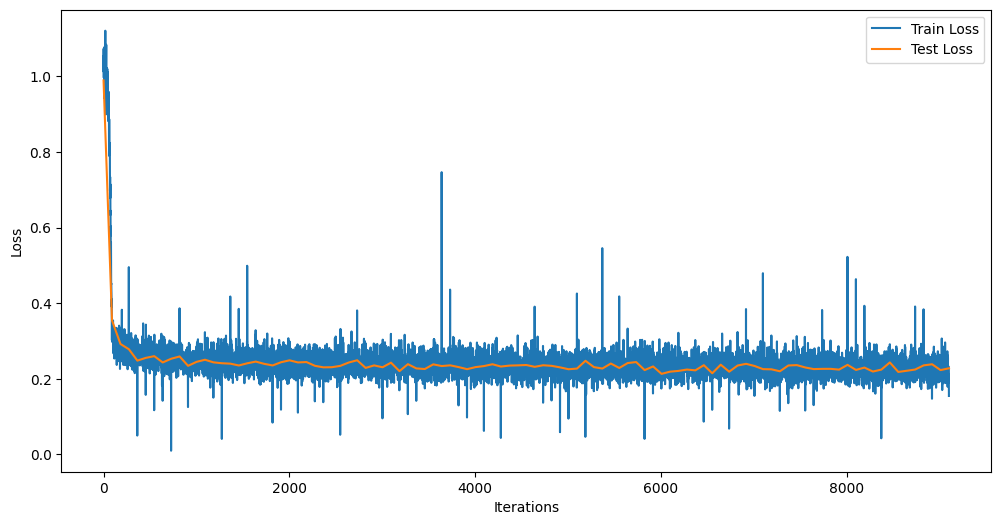

In [23]:
plot_losses(train_losses, test_losses)

## Sample

In [25]:
min_state, max_state

(array([0., 0., 0., 0., 0.], dtype=float32),
 array([496.14618  , 510.9579   , 439.9153   , 485.6641   ,   6.2830877],
       dtype=float32))

In [59]:
return_steps = [512]
normalized_samples = sample(
    diffusion,
    num_samples=10000,
    return_steps=return_steps,
    data_shape=5,
    clip=(-1, 1),
    device=device,
)

In [60]:
state_denormalizer = functools.partial(
    denormalize_pn1, min_val=min_state, max_val=max_state
)
samples = state_denormalizer(normalized_samples)

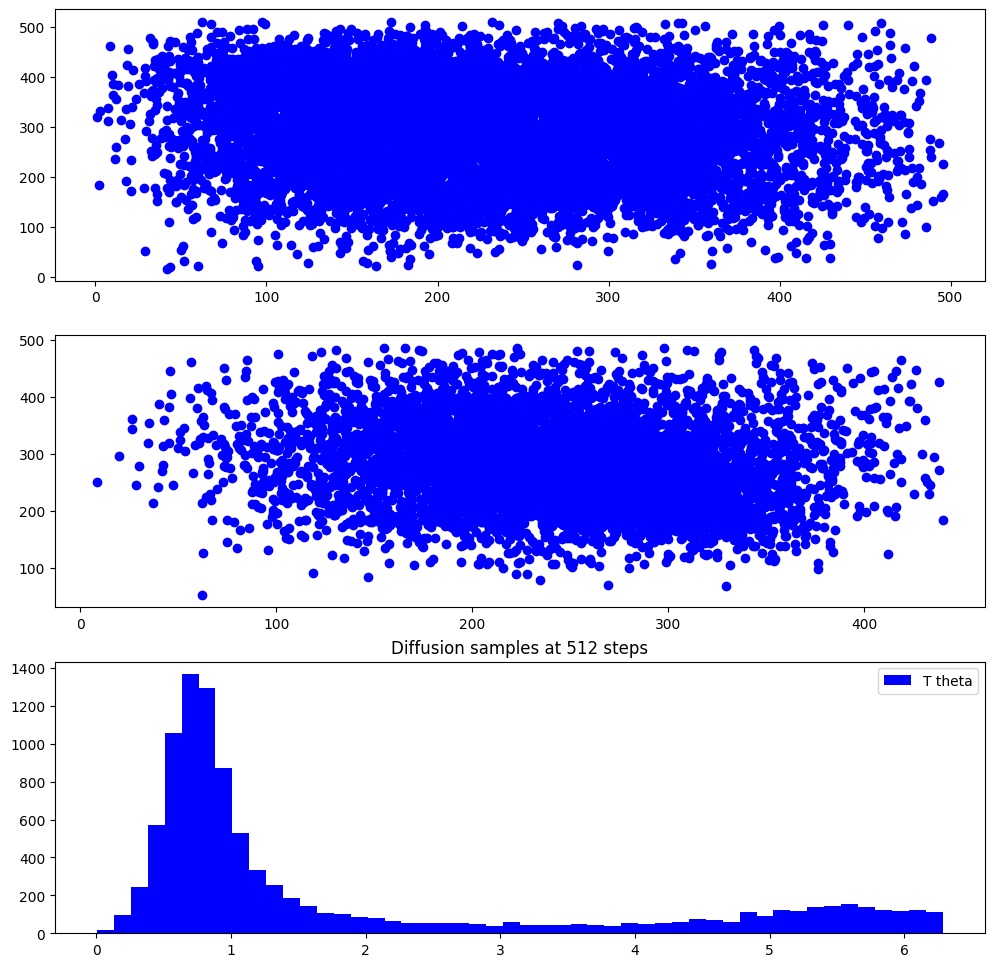

In [61]:
for i, steps in enumerate(return_steps):
    step_samples = samples[i]

    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].scatter(step_samples[:, 0], step_samples[:, 1], c="blue", label="robot xy")
    ax[1].scatter(step_samples[:, 2], step_samples[:, 3], c="blue", label="T xy")
    ax[2].hist(step_samples[:, 4], bins=50, color="blue", label="T theta")
    plt.legend()
    plt.title(f"Diffusion samples at {steps} steps")
    plt.show()

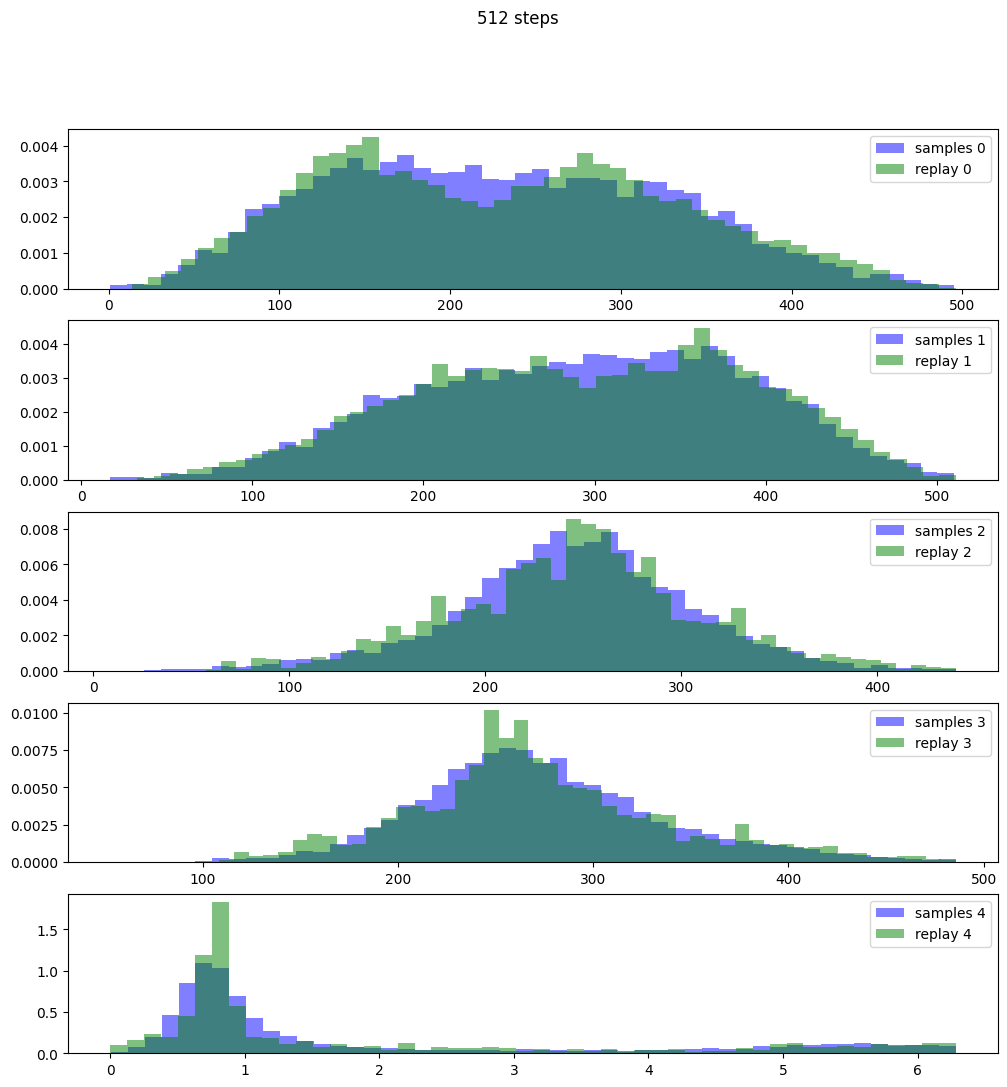

In [62]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(return_steps):
    step_samples = samples[i]

    fig, ax = plt.subplots(5, 1, figsize=(12, 12))
    for i in range(step_samples.shape[-1]):
        ax[i].hist(
            step_samples[:, i],
            density=True,
            bins=50,
            color="blue",
            alpha=0.5,
            label=f"samples {i}",
        )
        ax[i].hist(
            dataset.replay_buffer["state"][:, i],
            density=True,
            bins=50,
            color="green",
            alpha=0.5,
            label=f"replay {i}",
        )
        ax[i].legend()

    fig.suptitle(f"{steps} steps")
    plt.show()